# Lecture 3: Model Selection
Joaquin Vanschoren, Eindhoven University of Technology

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['figure.dpi'] = 120 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Evaluation
- To know whether we can _trust_ our method or system, we need to evaluate it.
- If you cannot measure it, you cannot improve it.
- Model selection: choose between different models in a data-driven way.
- Convince others that your work is meaningful
    - Peers, leadership, clients, yourself(!)
- Keep evaluating relentlessly, adapt to changes

## Designing Machine Learning systems

* Just running your favourite algorithm is usually not a great way to start
* Consider the problem at large
    - Do you want to understand phenomena or do black box modelling?
    - How to define and measure success? Are there costs involved?
    - Do you have the right data? How can you make it better?
* Build prototypes early-on to evaluate the above.

* Analyze your model's mistakes
    - Should you collect more, or additional data?
    - Should the task be reformulated?
    - Often a higher payoff than endless finetuning
* Technical debt: creation-maintenance trade-off
    - Very complex machine learning systems are hard/impossible to put into practice
    - See 'Machine Learning: The High Interest Credit Card of Technical Debt'

<img src="../images/eval_debt2.png" alt="ml" style="width: 800px;"/>

### Real world evaluations
* Evaluate predictions, but also how outcomes improve _because of them_
* Feedback loops: predictions are fed into the inputs, e.g. as new data, invalidating models
    * Example: a medical recommendation model may change future measurements
* The signal your model found may just be an artifact of your biased data
    - When possible, try to _interpret_ what your model has learned 
    - See 'Why Should I Trust You?' by Marco Ribeiro et al.
<img src="../images/eval_trust.png" alt="ml" style="width: 400px;"/>
* Adversarial situations (e.g. spam filtering) can subvert your predictions
* Do A/B testing (or bandit testing) to evaluate algorithms in the wild 

### A/B and bandit testing
* Test a single innovation (or choose between two models)
* Have most users use the old system, divert small group to new system
* Evaluate and compare performance
* Bandit testing: smaller time intervals, direct more users to currently winning system

<img src="../images/eval_abbandit.png" alt="ml" style="width: 600px;"/>

# Performance estimation techniques
* We do not have access to future observations
* Always evaluate models _as if they are predicting the future_
* Set aside data for objective evaluation
    * How?

## The holdout (simple train-test split)
- _Randomly_ split data (and corresponding labels) into training and test set (e.g. 75%-25%)
- Train (fit) a model on the training data, score on the test data

In [2]:
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit, train_test_split,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
from matplotlib.patches import Patch
np.random.seed(1338)
cmap_data = plt.cm.brg
cmap_group = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
rng = np.random.RandomState(42)
group_prior = rng.dirichlet([2]*10)
rng.multinomial(100, group_prior)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))


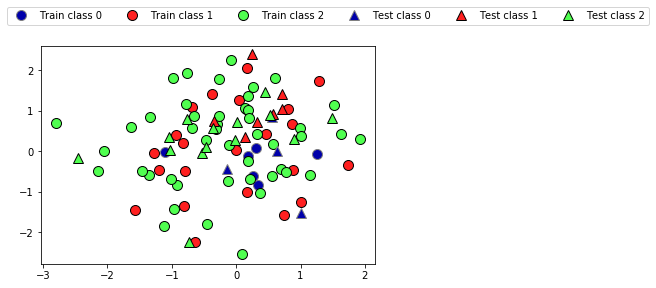

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
fig = plt.figure()
ax = fig.add_subplot(111)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                         markers='o', ax=ax)
mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                         markers='^', ax=ax)
ax.legend(["Train class 0", "Train class 1", "Train class 2", "Test class 0",
                "Test class 1", "Test class 2"], ncol=6,  loc=(-0.1, 1.1));

## K-fold Cross-validation
- Each random split can yield very different models (and scores)
    - e.g. all easy (of hard) examples could end up in the test set
- Split data (randomly) into _k_ equal-sized parts, called _folds_
    - Create _k_ splits, each time using a different fold as the test set
- Compute _k_ evaluation scores, aggregate afterwards (e.g. take the mean)
- Examine the score variance to see how _sensitive_ (unstable) models are
- Reduces sampling bias by testing on every point exactly once
- Large _k_ gives better estimates (more training data), but is expensive

In [4]:
def plot_cv_indices(cv, X, y, group, ax, lw=2, show_groups=False, s=700, legend=True):
    """Create a sample plot for indices of a cross-validation object."""
    n_splits = cv.get_n_splits(X, y, group)

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter([n_splits - ii - 1] * len(indices), range(len(indices)),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2, s=s)

    # Plot the data classes and groups at the end
    ax.scatter([-1] * len(X), range(len(X)), 
               c=y, marker='_', lw=lw, cmap=cmap_data, s=s)
    yticklabels = ['class'] + list(range(1, n_splits + 1))
    
    if show_groups:
        ax.scatter([-2] * len(X), range(len(X)), 
                   c=group, marker='_', lw=lw, cmap=cmap_group, s=s)
        yticklabels.insert(0, 'group')

    # Formatting
    ax.set(xticks=np.arange(-1 - show_groups, n_splits), xticklabels=yticklabels,
            ylabel='Sample index', xlabel="CV iteration",
            xlim=[-1.5 - show_groups, n_splits+.2], ylim=[-6, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    if legend:
        ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
                  ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks(())
    return ax

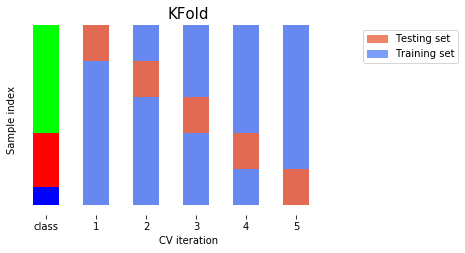

In [5]:
fig, ax = plt.subplots(figsize=(6, 3.5))
cv = KFold(5)
plot_cv_indices(cv, X, y, groups, ax, s=700);

### Stratified K-Fold cross-validation

- If the data is _unbalanced_, some classes have many fewer samples
- Likely that some classes are not present in the test set 
- Stratification: _proportions_ between classes are conserved in each fold
    - Order examples per class
    - Separate the samples of each class in _k_ sets (strata)
    - Combine corresponding strate into folds

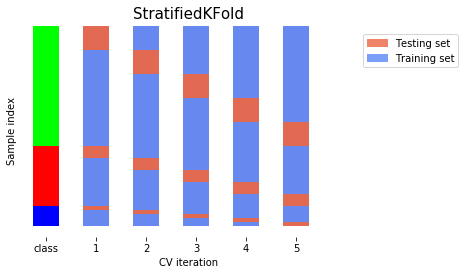

In [6]:
fig, ax = plt.subplots(figsize=(6, 3.9))
cv = StratifiedKFold(5)
plot_cv_indices(cv, X, y, groups, ax, s=700)
ax.set_ylim((-6, 100));

Can you explain this result?

``` python
kfold = KFold(n_splits=3)
print("Cross-validation scores KFold(n_splits=3):\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))
```

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()
kfold = KFold(n_splits=3)
print("Cross-validation scores KFold(n_splits=3):\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores KFold(n_splits=3):
[0. 0. 0.]


### Leave-One-Out cross-validation

- _k_ fold cross-validation with _k_ equal to the number of samples
- Completely unbiased (in terms of data splits), but computationally expensive
- But: generalizes _less_ well towards unseen data
    - The training sets are correlated (overlap heavily)
    - Overfits on the data used for (the entire) evaluation
    - A different sample of the data can yield different results
- Recommended only for small datasets

### Shuffle-Split cross-validation
- Additionally shuffles the data (only do this when the data is not ordered)
- Samples a number of samples (`train_size`) randomly as the training set
- Can also use a smaller (`test_size`), handy when using very large datasets

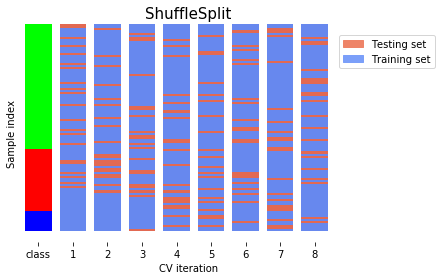

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
cv = ShuffleSplit(8, test_size=.2)
plot_cv_indices(cv, X, y, groups, ax, n_splits, s=700)
ax.set_ylim((-6, 100))
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
          ['Testing set', 'Training set'], loc=(.95, .8));

Note: this is related to _bootstrapping_:
- Sample _n_ (total number of samples) data points, with replacement, as training set (the bootstrap)
- Use the unsampled (out-of-bootstrap) samples as the test set
- Repeat `n_iter` times, obtaining `n_iter` scores
- Not supported in scikit-learn, only approximated
    - Use Shuffle-Split with `train_size=0.66`, `test_size=0.34`
    - You can prove that bootstraps include 66% of all data points on average 

### Repeated cross-validation
- Cross-validation is still biased in that the initial split can be made in many ways
- Repeated, or n-times-k-fold cross-validation:
    - Shuffle data randomly, do k-fold cross-validation
    - Repeat n times, yields n times k scores
- Unbiased, very robust, but n times more expensive

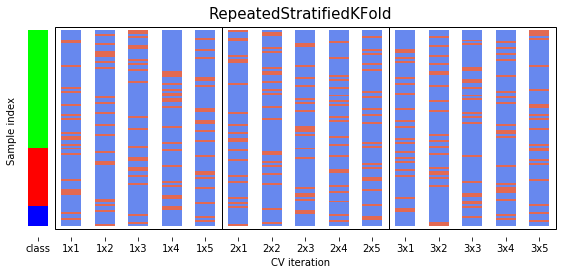

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(10, 3.9))
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
plot_cv_indices(cv, X, y, groups, ax, lw=2, s=400, legend=False)
ax.set_ylim((-6, 102))
xticklabels = ["class"] + [f"{repeat}x{split}" for repeat in range(1, 4) for split in range(1, 6)]
ax.set_xticklabels(xticklabels)
for i in range(3):
    rect = Rectangle((-.5 + i * 5, -2.), 5, 103, edgecolor='k', facecolor='none')
    ax.add_artist(rect)

### Cross-validation with groups

- Sometimes the data contains inherent groups:
    - Multiple samples from same patient, images from same person,...
- With normal cross-validation, data from the same person may end up in the training _and_ test set
- We want to measure how well the model generalizes to _other_ people
- Make sure that data from one person are in _either_ the train or test set
    - This is called _grouping_ or _blocking_
    - Leave-one-subject-out cross-validation: test set for each subject

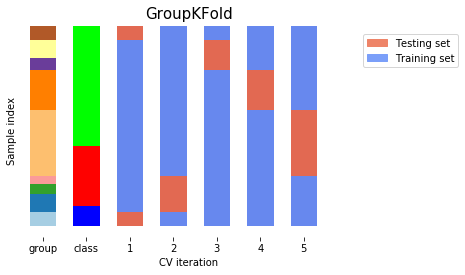

In [10]:
fig, ax = plt.subplots(figsize=(6, 3.9))
cv = GroupKFold(5)
plot_cv_indices(cv, X, y, groups, ax, s=700, show_groups=True)
ax.set_ylim((-6, 100));

### Time series
When the data is ordered, random test sets are not a good idea

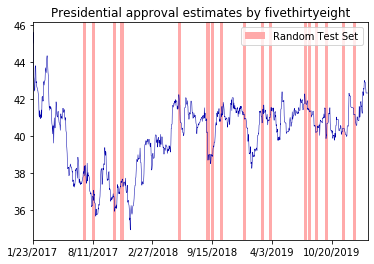

In [11]:
import pandas as pd
approval = pd.read_csv("https://projects.fivethirtyeight.com/trump-approval-data/approval_topline.csv")
adults = approval.groupby("subgroup").get_group('Adults')
adults = adults.set_index('modeldate')[::-1]
adults.approve_estimate.plot()
ax = plt.gca()
plt.rcParams["figure.figsize"] = [8,4]
ax.set_xlabel("")
xlim, ylim = ax.get_xlim(), ax.get_ylim()
for i in range(20):
    rect = Rectangle((np.random.randint(0, xlim[1]), ylim[0]), 10, ylim[1]-ylim[0], facecolor='#FFAAAA')
    ax.add_artist(rect)
plt.title("Presidential approval estimates by fivethirtyeight")
plt.legend([rect], ['Random Test Set'] );

### Time series
* Test-then-train (prequential evaluation)
    * Every new sample is evaluated on once, then added to the training set
    * Can also be done in batches (of _n_ samples at a time) 
* `TimeSeriesSplit`
    * In the kth split, the first k folds are used as the train set and the (k+1)th fold as the test set
    * Can also be done with a maximum training set size: more robust against concept drift

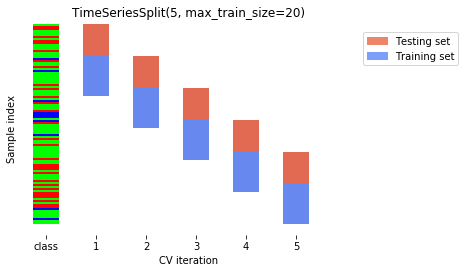

In [12]:
from sklearn.utils import shuffle
fig, ax = plt.subplots(figsize=(6, 3.9))
cv = TimeSeriesSplit(5, max_train_size=20)
plot_cv_indices(cv, X, shuffle(y), groups, ax, s=700, lw=2)
ax.set_ylim((-6, 100))
ax.set_title("TimeSeriesSplit(5, max_train_size=20)");

### Choosing a performance estimation procedure
No strict rules, only guidelines:

- Always use stratification for classification (sklearn does this by default)
- Use holdout for very large datasets (e.g. >1.000.000 examples)
    - Or when learners don't always converge (e.g. deep learning)
- Choose _k_ depending on dataset size and resources
    - Use leave-one-out for small datasets (e.g. <500 examples)
    - Use cross-validation otherwise
        - Most popular (and theoretically sound): 10-fold CV
        - Literature suggests 5x2-fold CV is better
- Use grouping or leave-one-subject-out for grouped data
- Use train-then-test for time series

# Evaluation Metrics and scoring
Keep the end-goal in mind

### Evaluation vs Optimization

- Each algorithm optimizes a given objective function (on the training data)
    - E.g. remember L2 loss in Ridge regression
$$\mathcal{L}_{ridge} = \sum_{i}(y_i - \sum_{j} x_{i,j}w_j)^2 + \alpha \sum_{i} w_i^2$$
- The choice of function is limited by what can be efficiently optimized
    - E.g. gradient descent requires a differentiable loss function
- However, we _evaluate_ the resulting model with a score that makes sense **in the real world**
    - E.g. percentage of correct predictions (on a test set)
- We also tune the algorithm's hyperparameters to maximize that score

### Binary classification

- We have a positive and a negative class
- 2 different kind of errors:
    - False Positive (type I error): model predicts positive while the true label is negative
    - False Negative (type II error): model predicts negative while the true label is positive
- They are not always equally important
    - Which side do you want to err on for a medical test?

#### Confusion matrices

- We can represent all predictions (correct and incorrect) in a confusion matrix
    - n by n array (n is the number of classes)
    - Rows correspond to true classes, columns to predicted classes
    - Each entry counts how often a sample that belongs to the class corresponding to the row was classified as the class corresponding to the column.
    - For binary classification, we label these true negative (TN), true positive (TP), false negative (FN), false positive (FP)

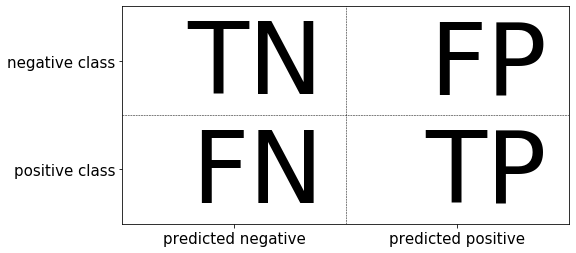

In [13]:
mglearn.plots.plot_binary_confusion_matrix()

#### Predictive accuracy

- Accuracy is one of the measures we can compute based on the confusion matrix:

\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

- In sklearn: use `confusion_matrix` and `accuracy_score` from `sklearn.metrics`.
- Accuracy is also the default evaluation measure for classification

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, stratify=data.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("confusion_matrix(y_test, y_pred): \n", confusion_matrix(y_test, y_pred))
print("accuracy_score(y_test, y_pred): ", accuracy_score(y_test, y_pred))
print("model.score(X_test, y_test): ", lr.score(X_test, y_test))

confusion_matrix(y_test, y_pred): 
 [[48  5]
 [ 5 85]]
accuracy_score(y_test, y_pred):  0.9300699300699301
model.score(X_test, y_test):  0.9300699300699301


#### The problem with accuracy: imbalanced datasets

- The type of error plays an even larger role if the dataset is imbalanced
    - One class is much more frequent than the other, e.g. credit fraud
    - Is a 99.99% accuracy good enough? 
- Are these three models really equally good?

In [15]:
# From Applied Machine Learning
def plot_confusion_matrix(values, xlabel="predicted labels", ylabel="true labels", xticklabels=None,
                          yticklabels=None, cmap=None, vmin=None, vmax=None, ax=None,
                          fmt="{:.2f}", xtickrotation=45, norm=None):
    """Plot a matrix as heatmap with explicit numbers.
    Parameters
    ----------
    values : ndarray
        Two-dimensional array to visualize.
    xlabel : string, default=""
        Label for the x-axis.
    ylabel : string, default=""
        Label for the y-axis.
    xticklabels : list of string or None, default=None
        Tick labels for the x-axis.
    yticklabels : list of string or None, default=None
        Tick labels for the y-axis
    cmap : string or colormap
        Matpotlib colormap to use.
    vmin : int, float or None
        Minimum clipping value.
    vmax : int, float or None
        Maximum clipping value.
    ax : axes object or None
        Matplotlib axes object to plot into. If None, the current axes are
        used.
    fmt : string, default="{:.2f}"
        Format string to convert value to text.
    xtickrotation : float, default=45
        Rotation of the xticklabels.
    norm : matplotlib normalizer
        Normalizer passed to pcolor
    """
    import matplotlib.pyplot as plt
    if ax is None:
        ax = plt.gca()
    img = ax.pcolormesh(values, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    # this will allow us to access the pixel values:
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_xlim(0, values.shape[1])
    ax.set_ylim(0, values.shape[0])

    if xticklabels is None:
        xticklabels = [""] * values.shape[1]
    if yticklabels is None:
        yticklabels = [""] * values.shape[0]

    # +.5 makes the ticks centered on the pixels
    ax.set_xticks(np.arange(values.shape[1]) + .5)
    ax.set_xticklabels(xticklabels, ha="center", rotation=xtickrotation)
    ax.set_yticks(np.arange(values.shape[0]) + .5)
    ax.set_yticklabels(yticklabels, va="center")
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            # pixel bright: use black for number
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt.format(value), color=c, ha="center", va="center")
    ax.invert_yaxis()
    return ax

In [16]:
# Artificial 90-10 imbalanced target
y_true = np.zeros(100, dtype=int)
y_true[:10] = 1
y_pred_1 = np.zeros(100, dtype=int)
y_pred_2 = y_true.copy()
y_pred_2[10:20] = 1
y_pred_3 = y_true.copy()
y_pred_3[5:15] = 1 - y_pred_3[5:15]

def plot_measure(measure):
    fig, axes = plt.subplots(1, 3)
    for i, (ax, y_pred) in enumerate(zip(axes, [y_pred_1, y_pred_2, y_pred_3])):
        plot_confusion_matrix(confusion_matrix(y_true, y_pred), cmap='gray_r', ax=ax,
                              xticklabels=["N", "P"], yticklabels=["N", "P"], xtickrotation=0, vmin=0, vmax=100)
        ax.set_title("{}: {:.2f}".format(measure.__name__,measure(y_true, y_pred)))

    plt.tight_layout()
    
plt.rcParams['figure.dpi'] = 120 # Use 300 for PDF, 100 for slides

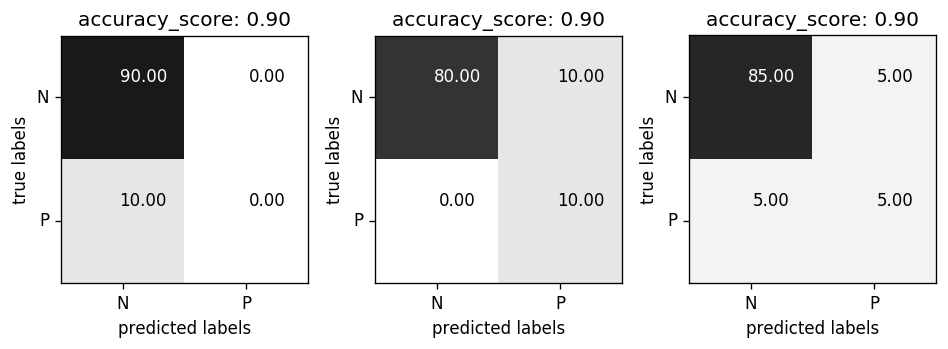

In [17]:
plot_measure(accuracy_score)

__Precision__ is used when the goal is to limit FPs
- Clinical trails: you only want to test drugs that really work
- Search engines: you want to avoid bad search results

\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

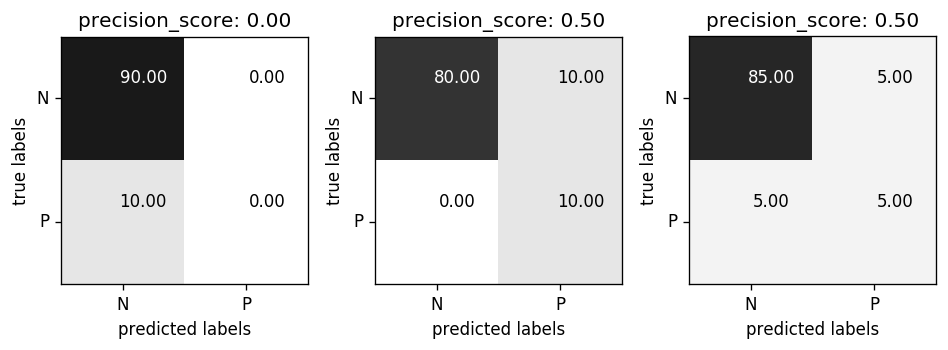

In [18]:
from sklearn.metrics import precision_score
plot_measure(precision_score)

__Recall__ is used when the goal is to limit FNs
- Cancer diagnosis: you don't want to miss a serious disease
- Search engines: You don't want to omit important hits
- Also know as sensitivity, hit rate, true positive rate (TPR)

\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

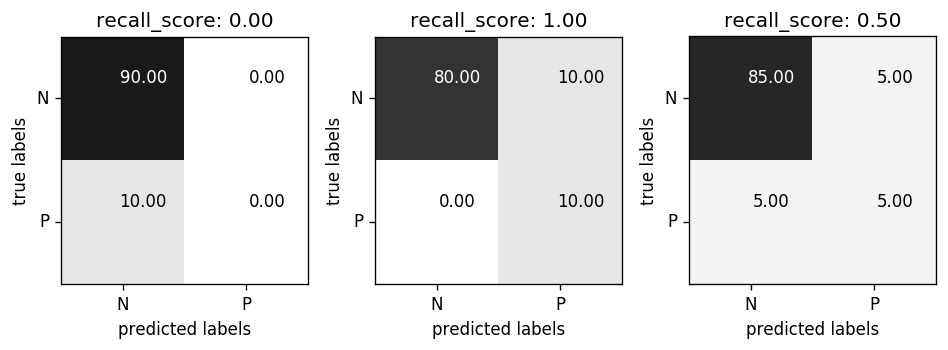

In [19]:
from sklearn.metrics import recall_score
plot_measure(recall_score)

__Comparison__   
![](images/07_precision-recall.jpg)
[//]: # "https://en.wikipedia.org/wiki/Precision_and_recall"

__F1-score__ or F1-measure trades off precision and recall:

\begin{equation}
\text{F1} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{equation}

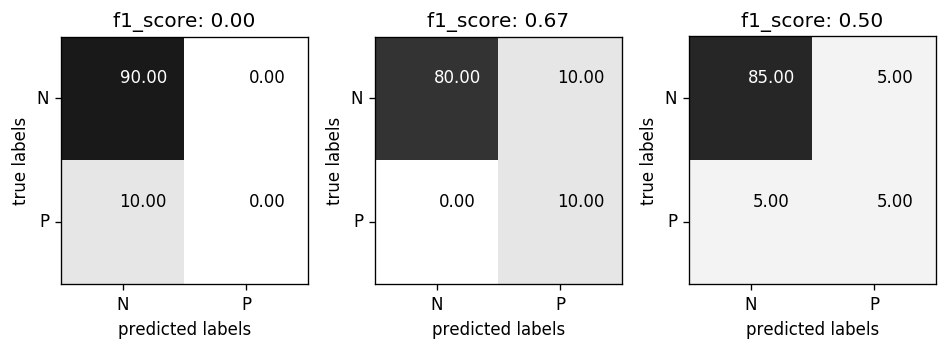

In [20]:
from sklearn.metrics import f1_score
plot_measure(f1_score)

__Classification measure Zoo__   
![](../images/07_zoo.png)
https://en.wikipedia.org/wiki/Precision_and_recall

Averaging scores per class
- Study the scores _by class_ (in scikit-learn: `classification_report`)
    - One class viewed as positive, other(s) als negative
    - Support: number of samples in each class
    - Last line: weighted average over the classes (weighted by number of samples in each class)
- Averaging for scoring measure R across C classes (also for multiclass):
    - micro: count total number of TP, FP, TN, FN
    - macro $$\frac{1}{C} \sum_{c \in C} R(y_c,\hat{y_c})$$
    - weighted ($w_c$: ratio of examples of class $c$) $$\sum_{c \in C} w_c R(y_c,\hat{y_c})$$

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        90
           1       0.00      0.00      0.00        10

    accuracy                           0.90       100
   macro avg       0.45      0.50      0.47       100
weighted avg       0.81      0.90      0.85       100



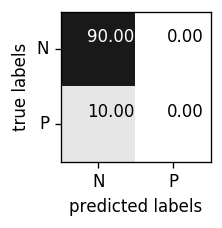

In [21]:
from sklearn.metrics import classification_report

def report(y_pred):
    print(classification_report(y_true, y_pred))
    fig, ax = plt.subplots(figsize=(2, 2))
    plt.rcParams['figure.dpi'] = 100 # Use 300 for PDF, 100 for slides
    plot_confusion_matrix(confusion_matrix(y_true, y_pred), cmap='gray_r', ax=ax,
                          xticklabels=["N", "P"], yticklabels=["N", "P"], xtickrotation=0, vmin=0, vmax=100)
    plt.tight_layout();
report(y_pred_1)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        90
           1       0.50      1.00      0.67        10

    accuracy                           0.90       100
   macro avg       0.75      0.94      0.80       100
weighted avg       0.95      0.90      0.91       100



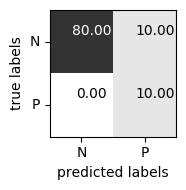

In [22]:
report(y_pred_2)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        90
           1       0.50      0.50      0.50        10

    accuracy                           0.90       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.90      0.90      0.90       100



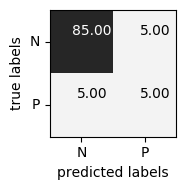

In [23]:
report(y_pred_3)

## Uncertainty estimates from classifiers
* Classifiers can often provide uncertainty estimates of predictions.  
* Remember that linear models actually return a numeric value.
    - When $\hat{y}<0$, predict class -1, otherwise predict class +1
    $$\hat{y} = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p + b $$  
* In practice, you are often interested in how certain a classifier is about each class prediction (e.g. cancer treatments).  


Scikit-learn offers 2 functions. Often, both are available for every learner, but not always.

- decision_function: returns floating point value for each sample
- predict_proba: return probability for each class

### The Decision Function
In the binary classification case, the return value of decision_function encodes how strongly the model believes a data point 
to belong to the “positive” class.  
- Positive values indicate a preference for the "positive" class
- Negative values indicate a preference for the "negative" (other) class

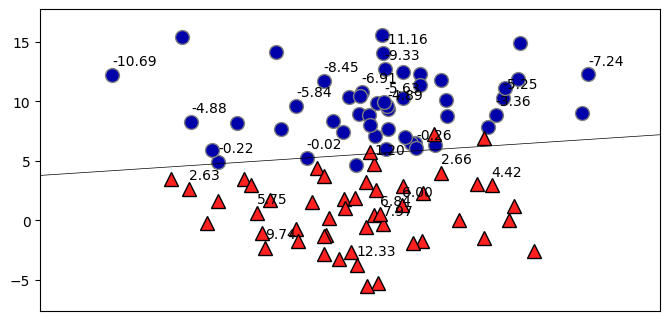

In [69]:
# create and split a synthetic dataset
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=2, cluster_std=2.5, random_state=8)

# we rename the classes "blue" and "red"
y_named = np.array(["blue", "red"])[y]

# we can call train test split with arbitrary many arrays
# all will be split in a consistent manner
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# build the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train_named)

# get the decision function
dec = lr.decision_function(X_test)

mglearn.plots.plot_2d_separator(lr, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);
plt.rcParams['figure.dpi'] = 90

for i, v in enumerate(dec):
    plt.annotate("{:.2f}".format(v), (X_test[i,0],X_test[i,1]),
                 textcoords="offset points", xytext=(0,7))

* The range of decision_function can be arbitrary, and depends on the data and the model parameters. This makes it sometimes hard to interpret.
* We can visualize the decision function as follows, with the actual decision boundary left and the values of the decision boudaries color-coded on the right.  
* Note how the test examples are labeled depending on the decision function.

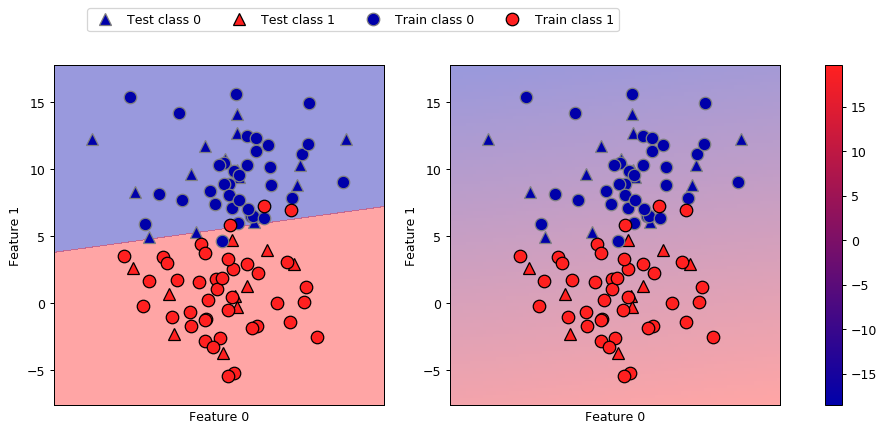

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(lr, X, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(lr, X, ax=axes[1],
                                            alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1));  

### Predicting probabilities
The output of predict_proba is a _probability_ for each class, with one column per class. They sum up to 1.

In [26]:
print("Shape of probabilities: {}".format(lr.predict_proba(X_test).shape))
# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(
      lr.predict_proba(X_test[:6])))

Shape of probabilities: (25, 2)
Predicted probabilities:
[[0.232 0.768]
 [0.002 0.998]
 [0.    1.   ]
 [0.003 0.997]
 [0.001 0.999]
 [1.    0.   ]]


We can visualize them again. Note that the gradient looks different now.

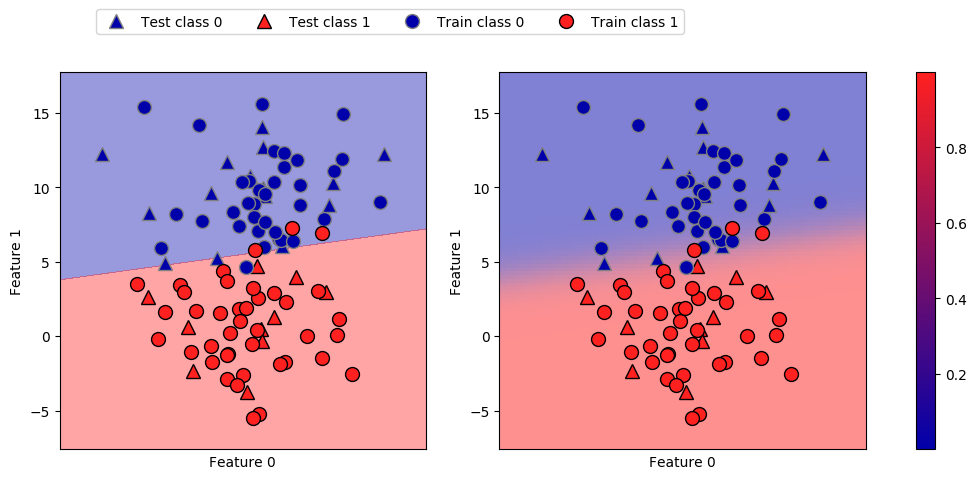

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(
    lr, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    lr, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
# don't want a transparent colorbar
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1));

### Interpreting probabilities

- The class with the highest probability is predicted.
- How well the uncertainty actually reflects uncertainty in the data depends on the model and the parameters. 
    - An overfitted model tends to make more certain predictions, even if they might be wrong. 
    - A model with less complexity usually has more uncertainty in its predictions. 
- A model is called _calibrated_ if the reported uncertainty actually matches how correct it is
    — A prediction made with 70% certainty would be correct 70% of the time.
    - LogisticRegression returns well calibrated predictions by default as it directly optimizes log-loss
    - Linear SVM are not well calibrated. They are _biased_ towards points close to the decision boundary.
- [Calibration techniques](http://scikit-learn.org/stable/modules/calibration.html) can calibrate models in post-processing.

### Model calibration

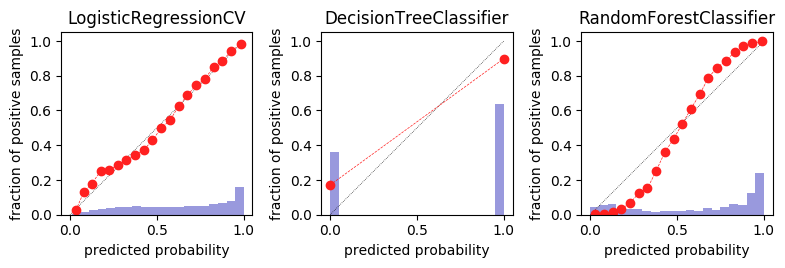

In [28]:
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

from sklearn.datasets import fetch_covtype
from sklearn.utils import check_array

def load_data(dtype=np.float32, order='C', random_state=13):
    ######################################################################
    # Load covertype dataset (downloads it from the web, might take a bit)
    # TODO: Use OpenML version
    data = fetch_covtype(download_if_missing=True, shuffle=True,
                         random_state=random_state)
    X = check_array(data['data'], dtype=dtype, order=order)
    # make it bineary classification
    y = (data['target'] != 1).astype(np.int)

    # Create train-test split (as [Joachims, 2006])
    n_train = 522911
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    # Standardize first 10 features (the numerical ones)
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    mean[10:] = 0.0
    std[10:] = 1.0
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

# subsample training set by a factor of 10:
X_train = X_train[::10]
y_train = y_train[::10]

#probs = lr.predict_proba(X_test)[:, 1]
#prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=5)

from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV().fit(X_train, y_train)

def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve

fig, axes = plt.subplots(1, 3, figsize=(8, 8))
for ax, clf in zip(axes, [LogisticRegressionCV(), DecisionTreeClassifier(),
                          RandomForestClassifier()]):
        # use predict_proba is the estimator has it
        scores = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        plot_calibration_curve(y_test, scores, n_bins=20, ax=ax)
        ax.set_title(clf.__class__.__name__)

plt.tight_layout();

### Model calibration

* Build another model, mapping classifier probabilities to better probabilities!
* 1d model! (or more for multi-class)
$$f_{calib}(s(x))≈p(y)$$

* s(x) is score given by model, usually
* Can also work with models that don’t even provide probabilities! Need model for f_{calib}, need to decide what data to train it on.
* Can train on training set, causes overfit
* Can train using cross-validation, slower

### Platt Scaling
* Use a logistic sigmoid for $f_{calib}$
$$f_{platt}=\frac{1}{1+\exp(−ws(x)−b)}$$

* Basically learning a 1d logistic regression (+ some tricks)
* Works well for SVMs


### Isotonic regression
* Very flexible way to specify $f_{calib}
* Learns arbitrary monotonically increasing step-functions in 1d.
* Groups data into constant parts, steps in between.
* Optimum monotone function on training data (wrt MSE)

<img src="../images/isotonic.png" alt="ml" style="width: 500px;"/>

## Taking uncertainty into account

- Remember that many classifiers actually return a probability per class
    - We can retrieve it with `decision_function` and `predict_proba`
- For binary classification, we threshold at 0 for  `decision_function` and 0.5 for `predict_proba` by default
- However, depending on the evaluation measure, you may want to threshold differently to fit your goals
    - For instance, when a FP is much worse than a FN
    - This is called _threshold calibration_

- Imagine that we want to avoid misclassifying a positive (red) point
- Points within decision boundary (black line) are classified positive
- Lowering the decision treshold (bottom figure): fewer FN, more FP

In [29]:
from sklearn.svm import SVC
from mglearn.datasets import make_blobs 
X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2],        
                  random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.5).fit(X_train, y_train)                                     

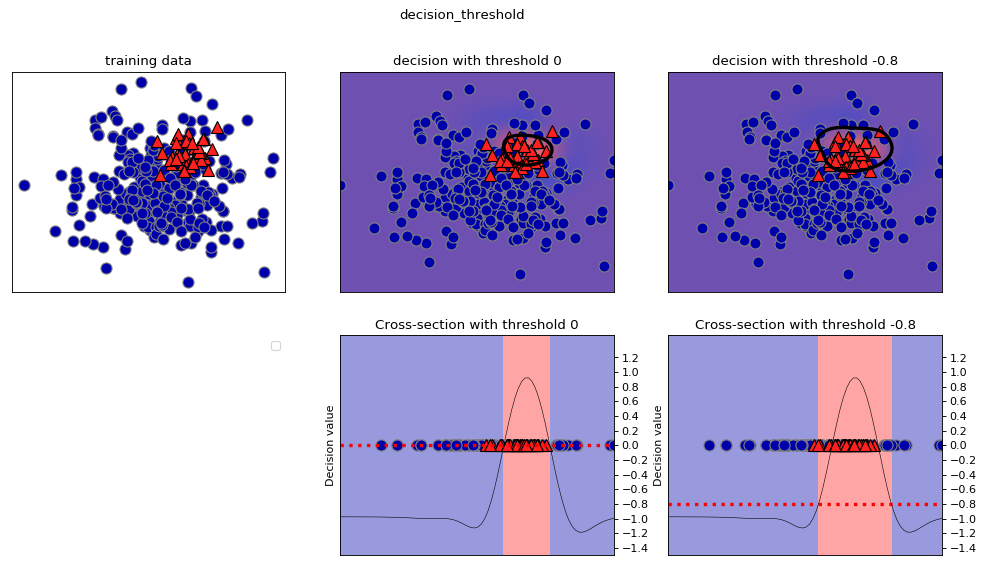

In [30]:
plt.rcParams['figure.dpi'] = 80 
mglearn.plots.plot_decision_threshold()

- Studying the classification report, we see that lowering the threshold yields:
    - higher recall for class 1 (we risk more FPs in exchange for more TP)
    - lower precision for class 1
- We can often trade off precision for recall

In [31]:
plt.rcParams['figure.dpi'] = 100 
print("Threshold 0")
print(classification_report(y_test, svc.predict(X_test)))

Threshold 0
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        96
           1       0.67      0.47      0.55        17

    accuracy                           0.88       113
   macro avg       0.79      0.71      0.74       113
weighted avg       0.87      0.88      0.88       113



In [32]:
print("Threshold -0.8")
y_pred_lower_threshold = svc.decision_function(X_test) > -.8
print(classification_report(y_test, y_pred_lower_threshold))  

Threshold -0.8
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        96
           1       0.65      0.88      0.75        17

    accuracy                           0.91       113
   macro avg       0.81      0.90      0.85       113
weighted avg       0.93      0.91      0.92       113



### Precision-Recall curves

- The best threshold depends on your application, should be driven by real-world goals.
- You can have arbitrary high recall, but you often want reasonable precision, too.
- It is not clear beforehand where the optimale trade-off (or _operating point_) will be, so it is useful to look at all possible thresholds
- Plotting precision against recall for all thresholds yields a __precision-recall curve__

- In scikit-learn, this is included in the `sklearn.metrics` module
- Returns all precision and recall values for all thresholds
    - Vary threshold from lowest to highest decision function score in the predictions
    - Or from highest to lowest class probability

In [33]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test)) 

- The default tradeoff (chosen by the `predict` method) is shown as _threshold zero_.
    - Higher threshold, more precision (move left)
    - Lower threshold, more recall (move right)
- The closer the curve stays to the upper-right corner, the better
    - High precision and high recall
- Here, it is possible to still get a precision of 0.5 with high recall

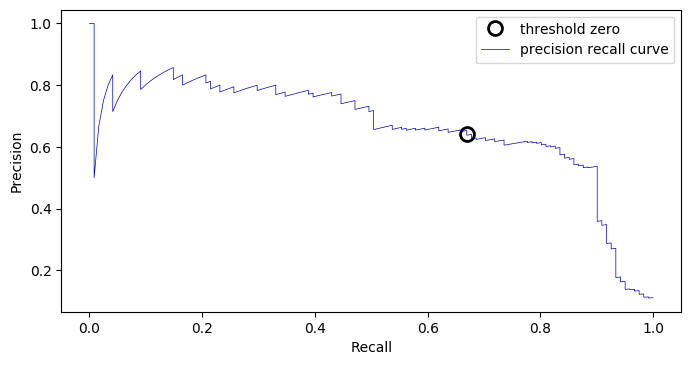

In [34]:
# create a similar dataset as before, but with more samples
# to get a smoother curve
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(recall, precision, label="precision recall curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

#### Model selection

- Different classifiers work best in different parts of the curve (at different operating points)
- RandomForest (in red) performs better at the extremes, SVM better in center
- The area under the precision-recall curve (AUPRC) is often used as a general evaluation measure

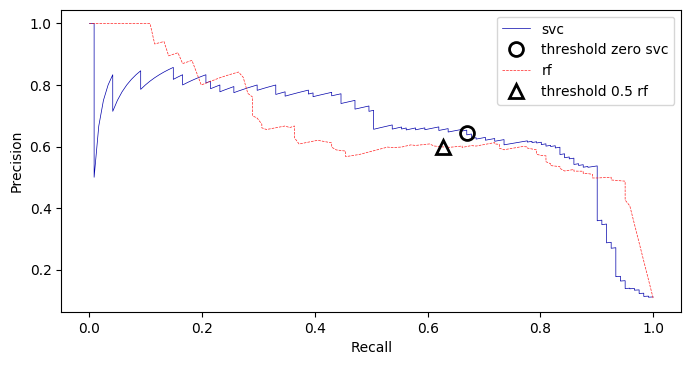

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
# Only pass probabilities for the positive class
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(recall, precision, label="svc")

plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(recall_rf, precision_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot( recall_rf[close_default_rf], precision_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

Note that the F1-measure completely misses these subtleties

In [36]:
print("f1_score of random forest: {:.3f}".format(
        f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


- The area under the precision-recall curve is returned by the `average_precision_score` measure 
    - It's actually a close approximation of the actual area
- This is a good automatic measure, but also hides the subtleties

In [37]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


### Receiver Operating Characteristics (ROC) and AUC

- There is another trade-off between recall (true positive rate, TPR) and the false positive rate (FPR).
- The 2D space created by TPR and FPR is called the Receiver Operating Characteristics (ROC) space
- A model will be at one point in this ROC space

\begin{equation}
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

\begin{equation}
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\end{equation}

- Varying the decision threshold yields the ROC curve
- It can be computed with the `roc_curve` function
    - Lower threshold, more recall/TPR, move right
    - High threshold, fewer FPs, move left
- Ideal is close to the top left: high recall, low FPR
- Inspect the curve to find the preferred calibration
    - Here, we can get much higher recall with slightly worse FPR

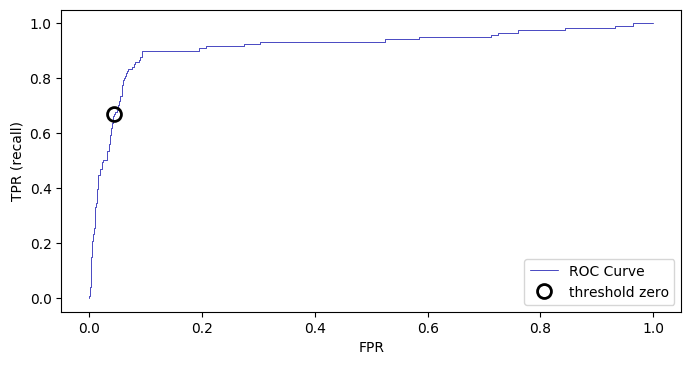

In [38]:
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

#### Visualization

- The blue probability density shows the probability p(x) that the model predicts blue if a data point has a certain predicted probability x to be blue. Same for red.
- In a random classifier the probability densities completely overlap.
- All points with a predicted probability higher than the threshold are predicted positive, others negative
- As we increase the threshold, we'll get fewer FPs, more FNs. We move from right to left along the ROC curve.

![roc](../images/03_roc.png)

#### ROC Isometrics
- Different _costs_ can be involved for FP and FN
- This yields different _isometrics_ (lines of equal cost) in ROC space
- The optimal threshold is the point on the ROC curve where the cost in minimal
    - If a FP and FN are weigthed equally, cost lines follow the diagonal (blue line)
    - If a FP is 10 times worse than a FN: pink line
    - IF a FN is 10 times worse than a FP: red line

![ROC cost curves](../images/03_roc_cost.png)

#### Model selection

- Again, we can compare multiple models by looking at the ROC curves
- We can calibrate the threshold depending on whether we need high recall or low FPR
- We can select between algorithms (or hyperparameters) depending on the involved costs.

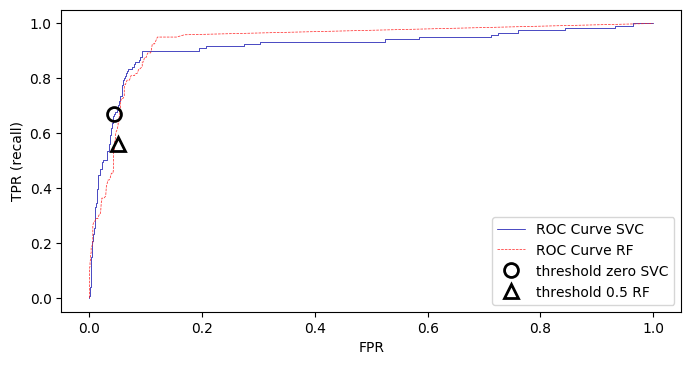

In [39]:
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4);

#### Area under the ROC curve

- A good summary measure is the area under the ROC curve (AUROC or AUC)
- Compute using the `roc_auc_score` 
    - Don't use `auc` (uses less accurate trapezoidal rule)
    
``` python
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
```

In [40]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


#### Imbalanced classes
- AUC is popular because it is insensitive to class imbalance
    - Random guessing always yields TPR=FPR
    - All points are on the diagonal line, hence an AUC of 0.5
    - Hint: use the visualization of TPR,FPR to see this

- Example: unbalanced digits
    - 3 models, ACC is the same, AUC not
    - If we optimize for ACC, our model could be just random guessing

gamma = 1.000  accuracy = 0.90  AUC = 0.5000
gamma = 0.100  accuracy = 0.90  AUC = 0.9582
gamma = 0.010  accuracy = 0.90  AUC = 0.9995


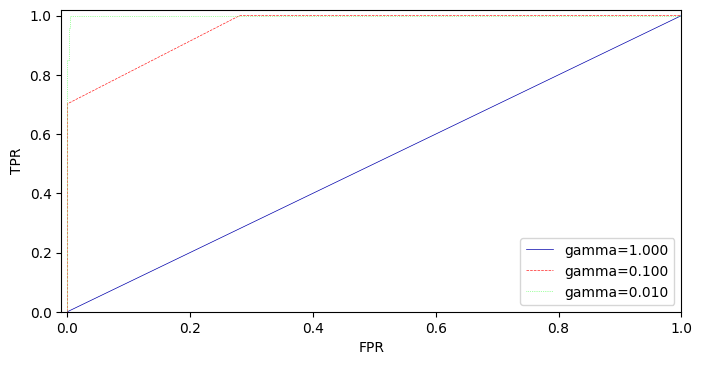

In [41]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()  

for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.3f}  accuracy = {:.2f}  AUC = {:.4f}".format(
            gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best");

#### Take home message

- AUC is highly recommended, especially on imbalanced data
- Remember to calibrate the threshold to your needs

### Linear Models for multiclass classification
Common technique: one-vs.-rest approach:

* A binary model is learned for each class vs. all other classes
* Creates as many binary models as there are classes
* Every binary classifiers makes a prediction, the one with the highest score (>0) wins

Build binary linear models:

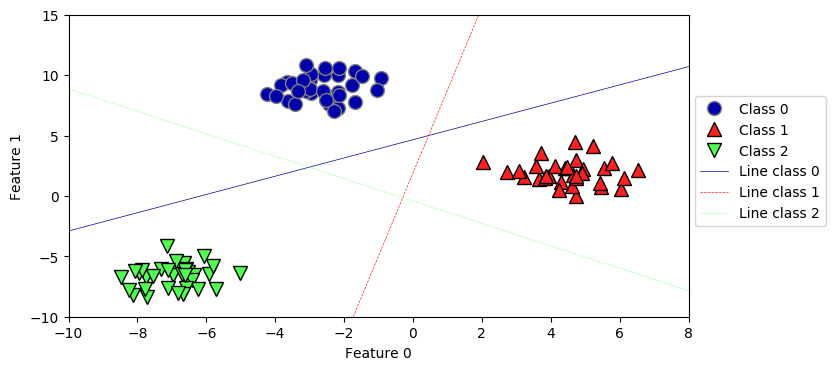

In [42]:
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC

X, y = make_blobs(random_state=42)
linear_svm = LinearSVC().fit(X, y)

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3));

Actual predictions (decision boundaries):

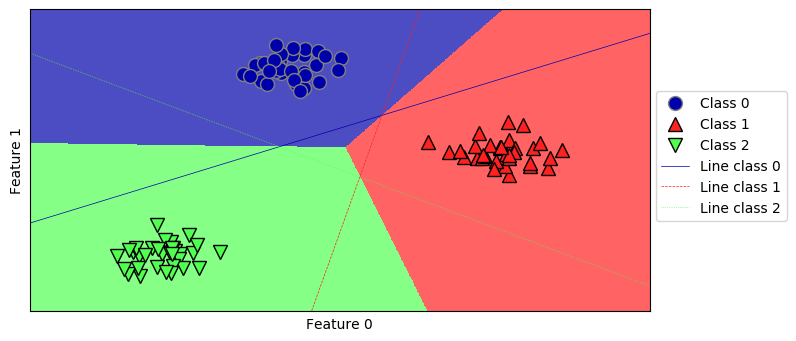

In [43]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

### Uncertainty in multi-class classification

- `decision_function` and `predict_proba` also work in the multiclass setting
- always have shape (n_samples, n_classes)
- Example on the Iris dataset, which has 3 classes:

In [44]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)

lr2 = LogisticRegression()
lr2 = lr2.fit(X_train, y_train)

print("Decision function:\n{}".format(lr2.decision_function(X_test)[:6, :]))
# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(lr2.predict_proba(X_test)[:6]))

Decision function:
[[ -3.035   2.294   0.741]
 [  5.919   3.091  -9.01 ]
 [-10.052   1.875   8.177]
 [ -2.733   2.036   0.697]
 [ -3.737   2.476   1.262]
 [  6.036   3.035  -9.07 ]]
Predicted probabilities:
[[0.004 0.822 0.174]
 [0.944 0.056 0.   ]
 [0.    0.002 0.998]
 [0.007 0.787 0.206]
 [0.002 0.77  0.229]
 [0.953 0.047 0.   ]]


### Multi-class classification

- Multiclass metrics are derived from binary metrics, averaged over all classes
- Let's consider the full (10-class) handwritten digit recognition data

Confusion matrix

In [45]:
from sklearn.metrics import accuracy_score
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.951
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  1 40  3  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  1  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  0  0  1  0  0  1 45]]


Visualized as a heatmap

- Which digits are easy to predict? Which ones are confused? 

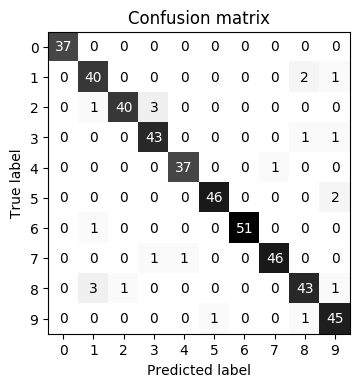

In [46]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

Precision, recall, F1-score now yield 10 per-class scores

In [47]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.93      0.91        43
           2       0.98      0.91      0.94        44
           3       0.91      0.96      0.93        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       1.00      0.98      0.99        52
           7       0.98      0.96      0.97        48
           8       0.91      0.90      0.91        48
           9       0.90      0.96      0.93        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



Different ways to compute average

- macro-averaging: computes unweighted per-class scores: 
$\frac{\sum_{i=0}^{n}score_i}{n}$
    - Use when you care about each class equally much

- weighted averaging: scores are weighted by the relative size of the classes (support): 
$\frac{\sum_{i=0}^{n}score_i weight_i}{n}$
    - Use when data is imbalanced

- micro-averaging: computes total number of FP, FN, TP over all classes, then computes scores using these counts: 
$recall = \frac{\sum_{i=0}^{n}TP_i}{\sum_{i=0}^{n}TP_i + \sum_{i=0}^{n}FN_i}$
    - Use when you care about each sample equally much

In [48]:
print("Micro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("Weighted average f1 score: {:.3f}".format(f1_score(y_test, pred, average="weighted")))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.951
Weighted average f1 score: 0.951
Macro average f1 score: 0.952


## Regression metrics

Most commonly used are
- (root) mean squared error: $\frac{\sum_{i}(y_{pred_i}-y_{actual_i})^2}{n}$
- mean absolute error: $\frac{\sum_{i}|y_{pred_i}-y_{actual_i}|}{n}$
    - Less sensitive to outliers and large errors
- R squared (r2): $1 - \frac{\sum_{i}(y_{pred_i}-y_{actual_i})^2}{\sum_{i}(y_{mean}-y_{actual_i})^2}$
    - Ratio of variation explained by the model / total variation
    - Between 0 and 1, but _negative_ if the model is worse than just predicting the mean
    - Easier to interpret (higher is better).

- R squared: 1 - ratio of $\sum_{i}(y_{pred_i}-y_{actual_i})^2$ (blue) and $\sum_{i}(y_{mean}-y_{actual_i})^2$ (red)
![r2](../images/07_r2.png)

#### Visualizing errors
* Prediction plot (left): predicted vs actual target values
* Residual plot (right): residuals vs actual target values
    * Over- and underpredictions can be given different costs 

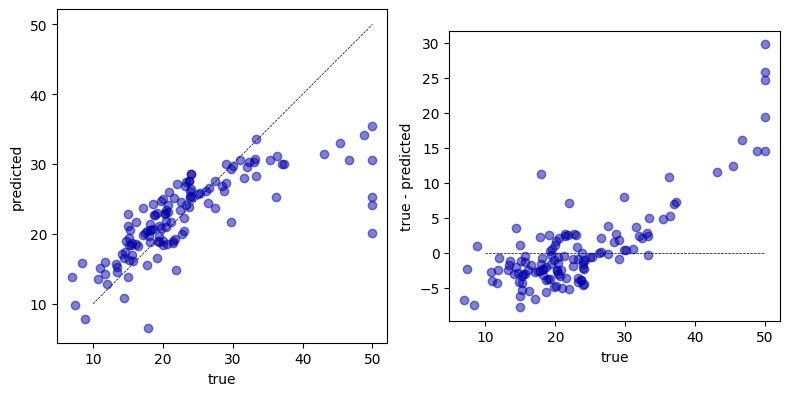

In [49]:
from sklearn.linear_model import Ridge
from sklearn.datasets import load_boston
boston = load_boston()

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target)

pred = Ridge(normalize=True).fit(X_train, y_train).predict(X_test)

plt.subplot(1, 2, 1)
plt.gca().set_aspect("equal")
plt.plot([10, 50], [10, 50], '--', c='k')
plt.plot(y_test, pred, 'o', alpha=.5)
plt.ylabel("predicted")
plt.xlabel("true");

plt.subplot(1, 2, 2)
plt.gca().set_aspect("equal")
plt.plot([10, 50], [0,0], '--', c='k')
plt.plot(y_test, y_test - pred, 'o', alpha=.5)
plt.xlabel("true")
plt.ylabel("true - predicted")
plt.tight_layout();

## Using evaluation metrics in model selection

- You typically want to use AUC or other relevant measures in `cross_val_score` and `GridSearchCV` instead of the default accuracy.
- scikit-learn makes this easy through the `scoring` argument
    - But, you need to need to look the [mapping between the scorer and the metric](http://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation)

![scorers](../images/03_scoring.png)

## Final thoughts
* There exist techniques to correct label imbalance
    - Undersample the majority class, or oversample the minority class
    - SMOTE (Synthetic Minority Oversampling TEchnique) adds articifial _training_ points by interpolating existing minority class points
        - Think twice before creating 'artificial' training data 
* Cost-sensitive classification (not in sklearn)
    - _Cost matrix_: a confusion matrix with a costs associated to every possible type of error
    - Some algorithms allow optimizing on these costs instead of their usual loss function
    - Meta-cost: builds ensemble of models by relabeling training sets to match a given cost matrix
        - Black-box: can make any algorithm cost sensitive (but slower and less accurate)

* There are many more metrics to choose from
    - Cohen's Kappa: accuracy, taking into account the possibility of predicting the right class by chance
        - 1: perfect prediction, 0: random prediction, negative: worse than random
        - With $p_0$ = accuracy, and $p_e$ = accuracy of random classifier:
            $$\kappa = \frac{p_o - p_e}{1 - p_e}$$
    - Balanced accuracy: accuracy where each sample is weighted according to the inverse prevalence of its true class
        - Identical to macro-averaged recall
    - Matthews correlation coefficient: another measure that can be used on imbalanced data
        - 1: perfect prediction, 0: random prediction, -1: inverse prediction
            $$MCC = \frac{tp \times tn - fp \times fn}{\sqrt{(tp + fp)(tp + fn)(tn + fp)(tn + fn)}}$$


## Bias-Variance decomposition

- When we repeat evaluation procedures multiple times, we can distinguish two sources of errors:
    - Bias: systematic error (independent of the training sample). The classifier always gets certain points wrong
    - Variance: error due to variability of the model with respect to the training sample. The classifier predicts some points accurately on some training sets, but inaccurately on others.
- There is also an intrinsic (noise) error, but there's nothing we can do against that.
- Bias is associated with underfitting, and variance with overfitting
- Bias-variance trade-off: you can often exchange variance for bias through regularization (and vice versa)
    - The challenge is to find the right trade-off (minimizing total error)
- Useful to understand how to tune or adapt learning algorithm

<img src="../images/03_bias_variance.png" alt="ml" style="width: 600px;"/>

- Sadly, this is not yet supported by scikit-learn
- How to measure bias and variance (for regression):
    - Take 100 or more bootstraps (or shuffle-splits)
    - For each data point x:
        - $bias(x)^2 = (x_{true} - mean(x_{predicted}))^2$
        - $variance(x) = var(x_{predicted})$
    - Total bias: $\sum_{x} bias(x)^2 * w_x$, with $w_x$ the ratio of x occuring in the test set
    - Total variance: $\sum_{x} variance(x) * w_x$

- General procedure for (binary) classification:
    - Take 100 or more bootstraps (or shuffle-splits)
    - Bias for any point x = misclassification ratio
        - If misclassified 50% of the time: $bias(x)=0.5$
    - Variance for any point x is $(1 - (P(class_1)^2 + P(class_2)^2))/2$
        - $P(class_i)$ is ratio of class $i$ predictions
        - When each class predicted half of the time: $variance(x) = (1-(0.5^2+0.5^2))/2 = 0.25$
    - Total bias: $\sum_{x} bias(x)^2 * w_x$, with $w_x$ the ratio of x occuring in the test data
    - Total variance: $\sum_{x} variance(x) * w_x$

``` python
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    clf.fit(X[train_index], y[train_index])
    y_pred = clf.predict(X[test_index])
    # Store predictions
    for i,index in enumerate(test_index):
        y_all_pred[index].append(y_pred[i])
        
# Compute bias, variance, error
bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])
var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
           for i,x in enumerate(y_all_pred)])
error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])
```

In [50]:
# Data and classifier
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)
clf = LogisticRegression()

# Bootstraps
n_repeat = 100
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

# Store sample predictions
y_all_pred = [[] for _ in range(len(y))]

# Train classifier on each bootstrap and score predictions
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    # Train and predict
    clf.fit(X[train_index], y[train_index])
    y_pred = clf.predict(X[test_index])

    # Store predictions
    for i,index in enumerate(test_index):
        y_all_pred[index].append(y_pred[i])
        
# Compute bias, variance, error
bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])
var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
           for i,x in enumerate(y_all_pred)])
error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

print("Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (bias_sq, var, error))

Bias squared: 12.65, Variance: 1.17, Total error: 13.82


### Bias-variance and overfitting
![Bias-variance-tradeoff](../images/03_Bias-Variance-Tradeoff.png)

- High bias means that you are likely underfitting
    - Do less regularization
    - Use a more flexible/complex model (another algorithm)
    - Use a bias-reduction technique (e.g. boosting, see later)
- High variance means that you are likely overfitting
    - Use more regularization
    - Get more data
    - Use a simpler model (another algorithm)
    - Use a variance-reduction techniques (e.g. bagging, see later)

Bias-Variance Flowchart (Andrew Ng, Coursera)
![Bias-variance-Flowchart](../images/03_Bias-Variance-Flowchart.png)

## Hyperparameter tuning
Now that we know how to evaluate models, we can improve them by tuning their hyperparameters

We can basically use any optimization technique to optimize hyperparameters:
 
- __Grid search__
- __Random search__

More advanced techniques:

- Local search
- Racing algorithms
- Model-based optimization (see later)
- Multi-armed bandits
- Genetic algorithms

### Grid Search

- For each hyperparameter, create a list of interesting/possible values
    - E.g. For kNN: k in [1,3,5,7,9,11,33,55,77,99]
- Evaluate all possible combination of hyperparameter values
    - E.g. using cross-validation
- Select the hyperparameter values yielding the best results
- A naive approach would be to just loop over all combinations

``` python
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination, train and evaluate an SVC
        svm = SVC(gamma=gamma, C=C);
        svm.fit(X_train, y_train);
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
```

In [51]:
# naive grid search implementation
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

# Note: we've seen the `C` parameter of SVMs, we'll see the `gamma` parameter later.
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination, train an SVC
        svm = SVC(gamma=gamma, C=C);
        svm.fit(X_train, y_train);
        # evaluate the SVC on the test set 
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


#### Overfitting the parameters and the validation set
- Simply taking the best performing model yields optimistic results
- We've already used the test data to evaluate each hyperparameter setting!
- Hence, we don't have an independent test set to evaluate these hyperparameter settings
    - Information 'leaks' from test set into the final model
- Solution: Set aside part of the training data to evaluate the hyperparameter settings
    - Select best hyperparameters on validation set
    - Rebuild the model on the training+validation set
    - Evaluate optimal model on the test set

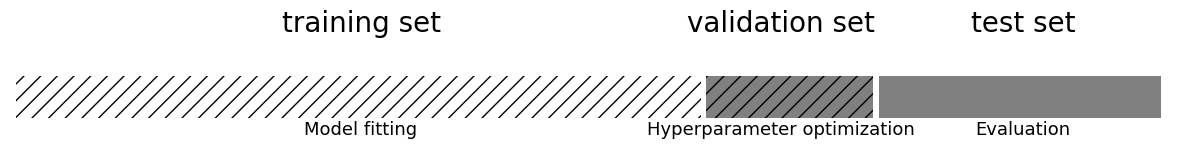

In [52]:
mglearn.plots.plot_threefold_split()

``` python
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
```

In [53]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set 
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


#### Grid-search with cross-validation

- Same problem as before: the way that we split the data into training, validation, and test set may have a large influence on estimated performance
- We need to use cross-validation again, instead of a single split
- Expensive. Often, 3 or 5-fold CV is enough

``` python
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
```

In [54]:
# manual grid search cv
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Overall process

In [55]:
plt.rcParams['savefig.dpi'] = 75 # Avoid overlapping boxes

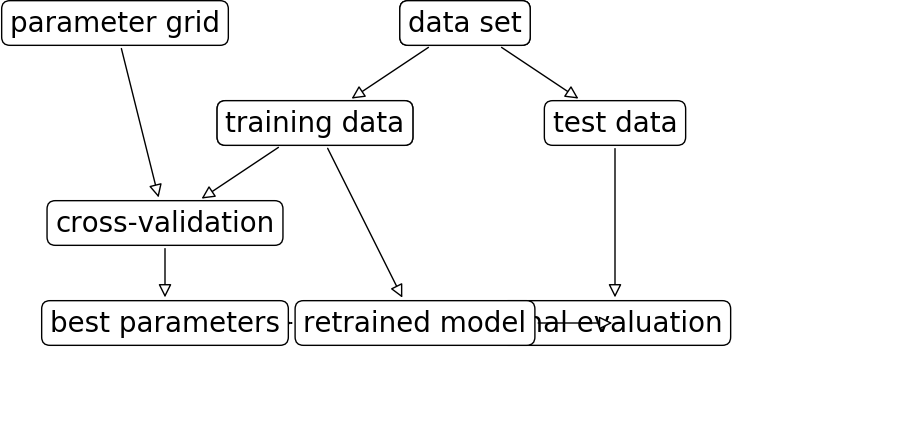

In [56]:
mglearn.plots.plot_grid_search_overview()

In [57]:
plt.rcParams['savefig.dpi'] = 100 # Back to normal

#### Grid search in scikit-learn
- Create a parameter grid as a dictionary
    - Keys are parameter names
    - Values are lists of hyperparameter values
    
``` python
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))
```

In [58]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


- `GridSearchCV`: like a classifier that uses CV to automatically optimize its hyperparameters internally
    - Input: (untrained) model, parameter grid, CV procedure
    - Output: optimized model on given training data
    - Should only have access to training data
    
``` python
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
```

In [59]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

The optimized test score and hyperparameters can easily be retrieved:

``` python
grid_search.score(X_test, y_test)
```

In [60]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


``` python
grid_search.best_params_
grid_search.best_score_
```

In [61]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


``` python
grid_search.best_estimator_
```

In [62]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


#### Visualizing hyperparameter impact
We can retrieve and visualize the cross-validation resulst to better understand the impact of hyperparameters
``` python
results = pd.DataFrame(grid_search.cv_results_)
```

In [63]:
import pandas as pd
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)
# Show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,...,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.11e-03,6.92e-05,7.93e-04,2.69e-04,...,0.41,0.37,0.02,22
1,8.40e-04,5.21e-04,3.60e-04,1.41e-04,...,0.41,0.37,0.02,22
2,1.08e-03,2.62e-04,5.50e-04,1.59e-04,...,0.41,0.37,0.02,22
3,1.44e-03,5.28e-04,1.51e-03,1.53e-03,...,0.41,0.37,0.02,22
4,7.66e-04,1.52e-04,3.51e-04,1.03e-04,...,0.41,0.37,0.02,22


Visualize as a heatmap

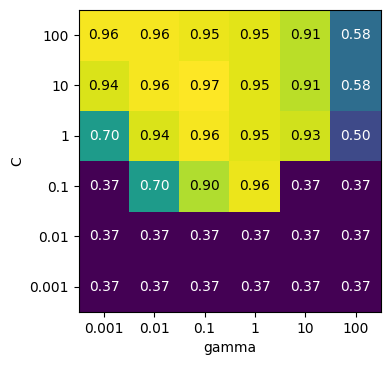

In [64]:
scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis");

When hyperparameters depend on other parameters, we can use lists of dictionaries to define the hyperparameter space

``` python
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
```

In [65]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


#### Nested cross-validation

- Note that we are still using a single split to create the outer test set
- We can also use cross-validation here
- Nested cross-validation:
    - Outer loop: split data in training and test sets
    - Inner loop: run grid search, splitting the training data into train and validation sets
- Result is a just a list of scores
    - There will be multiple optimized models and hyperparameter settings (not returned)
- To apply on future data, we need to train `GridSearchCV` on all data again

``` python
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
```

In [66]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.967 1.    0.9   0.967 1.   ]
Mean cross-validation score:  0.9666666666666668


#### Parallelizing cross-validation and grid-search
- On a practical note, it is easy to parallellize CV and grid search
- `cross_val_score` and `GridSearchCV` have a `n_jobs` parameter defining the number of cores it can use.
    - set it to `n_jobs=-1` to use all available cores.

### Random Search

- Grid Search has a few downsides:
    - Optimizing many hyperparameters creates a combinatorial explosion
    - You have to predefine a grid, hence you may jump over optimal values
- Random Search:
    - Picks `n_iter` random parameter values
    - Scales better, you control the number of iterations
    - Often works better in practice, too
        - not all hyperparameters interact strongly
        - you don't need to explore all combinations

- Executing random search in scikit-learn:
    - `RandomizedSearchCV` works like `GridSearchCV`
    - Has `n_iter` parameter for the number of iterations
    - Search grid can use distributions instead of fixed lists
    
``` python
param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,
                                   n_iter=20)
random_search.fit(X_train, y_train)
```

In [67]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,
                                   n_iter=20)
X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, random_state=0)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11c740470>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11c740ef0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

# Summary

- k-fold Cross-validation
    - Choose k depending on how much data you have
        - Larger k is slower, but allows more training data
        - 10-fold, 5-fold, 5x2-fold most popular
    - Always use stratification for (imbalanced) classification
    - Train-test split and Shuffle-split: useful for large datasets 
    - Use grouping when you want to generalize over groups
- Model selection
    - Don't aggregate over test scores: those have seen the test data
    - Use validation sets to choose algorithms/hyperparameters first
- Optimization
    - Grid Search: exhaustive but simple
    - Random Search: scales better
    - We'll see more advanced techniques later

# Summary
* Real-world data is often imbalanced 
* False positives may be much worse than false negatives (or vise-versa)
* Binary classification
    - Select metrics that can distinguish different types of errors (precision, recall, f1-score, AUC,...)
    - Calibrate decision thresholds to the task at hand
    - Precision-Recall and ROC curves: choose the best threshold or take area under the curve
* Multiclass classification
    - Macro/Micro/weighted average of per-class scores (one-vs-all)
* Regression
    - (Root) mean squared/absolute error from 0..Inf
    - R2 easier to interpret
* All measures can be used in cross-validation or grid/random search
* Cost-sensitive classification: optimize for any cost matrix or cost function